# Resnet50 on STL10 Dataset

## Fetch and Create Dataset
First, we will fetch the binary dataset from the site and extract it to my drive folder. Later I will convert them to image and put them into a folder respective to their class

### Import modules
First, let's import module to fetch dataset and store them

In [6]:
import os, sys, tarfile, errno
import numpy as np
import matplotlib.pyplot as plt

import urllib.request
from imageio import imsave
from tqdm import tqdm
import random
import shutil

### Define Paths
Here I have defined path to our data folder. THere we will keep all of our data for training and testing

In [7]:
HEIGHT = 96
WIDTH = 96
DEPTH = 3

SIZE = HEIGHT * WIDTH * DEPTH

DATA_DIR = './drive/MyDrive/stl10/all_data'
DATA_URL = 'http://ai.stanford.edu/~acoates/stl10/stl10_binary.tar.gz'

TRAIN_DATA_PATH = './drive/MyDrive/stl10/stl10_binary/train_X.bin'
TRAIN_LABEL_PATH = './drive/MyDrive/stl10/stl10_binary/train_y.bin'

TEST_DATA_PATH = './drive/MyDrive/stl10/stl10_binary/test_X.bin'
TEST_LABEL_PATH = './drive/MyDrive/stl10/stl10_binary/test_y.bin'

## Download Dataset
Now,let's start with downloading the dataset and extracting them into bin file

In [8]:
def download_and_extract():
  
  dest_directory = DATA_DIR
  if not os.path.exists(dest_directory):
      os.makedirs(dest_directory)
  filename = DATA_URL.split('/')[-1]
  filepath = os.path.join(dest_directory, filename)
  if not os.path.exists(filepath):
      def _progress(count, block_size, total_size):
          sys.stdout.write('\rDownloading %s %.2f%%' % (filename,
              float(count * block_size) / float(total_size) * 100.0))
          sys.stdout.flush()
      filepath, _ = urllib.request.urlretrieve(DATA_URL, filepath, reporthook=_progress)
      print('Downloaded', filename)
      tarfile.open(filepath, 'r:gz').extractall(dest_directory)

In [5]:
download_and_extract()

## Data Exploration
Now, that we have downloaded out data let's convert them to images and visualize them

### Function to read an image an visualize

In [9]:
def read_single_image(image_file):

  image = np.fromfile(image_file, dtype=np.uint8, count=SIZE)

  image = np.reshape(image, (3, 96, 96))
  image = np.transpose(image, (2, 1, 0))
  return image

def plot_image(image):
  
  plt.imshow(image)
  plt.show()

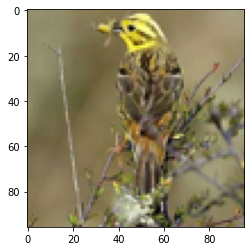

In [10]:
with open(TRAIN_DATA_PATH) as f:
  image = read_single_image(f)
  plot_image(image)

## Conversion and Store
Here we will convert the bin file to image file and store them to labeled folder. First we have defined some functions to read the labels and images bin file. Then, upon forcing the bin content to 3x96x96 chunks we will save the data to train, val and test folder. 

In [18]:
def read_labels(path_to_labels):

  with open(path_to_labels, 'rb') as f:
      labels = np.fromfile(f, dtype=np.uint8)
      return labels

def read_all_images(path_to_data):

  with open(path_to_data, 'rb') as f:
      everything = np.fromfile(f, dtype=np.uint8)

      images = np.reshape(everything, (-1, 3, 96, 96))
      images = np.transpose(images, (0, 3, 2, 1))
      return images

def save_image(image, name):
  imsave("%s.png" % name, image, format="png")

def save_images(images, labels, types):
  i = 0
  for image in tqdm(images, position=0):
      label = labels[i] 
      directory = DATA_DIR + '/' + types + '/' + str(label) + '/'
      try:
          os.makedirs(directory, exist_ok=True)
      except OSError as exc:
          if exc.errno == errno.EEXIST:
              pass
      filename = directory + str(i)
      #print(filename)
      save_image(image, filename)
      i = i+1
def create_val_dataset():
  train_image_path = "./drive/MyDrive/stl10/all_data/train"
  folders = os.listdir(train_image_path)

  for folder in tqdm(folders, position=0):
    temp_dir = DATA_DIR +"/train/" + folder
    temp_image_list = os.listdir(temp_dir)
    
    for i in range(50):
      val_dir = DATA_DIR + "/val/" + folder
      try:
          os.makedirs(val_dir, exist_ok=True)
      except OSError as exc:

          if exc.errno == errno.EEXIST:
              pass
      image_name = random.choice(temp_image_list)
      temp_image_list.remove(image_name)
      old_name = temp_dir + '/' + image_name
      new_name = val_dir + '/' + image_name
      os.replace(old_name, new_name)

Now, let's load the label and dataset and using above functions I will save them into my *drive/stl10/all_data* directory

In [12]:
train_labels = read_labels(TRAIN_LABEL_PATH)
train_images = read_all_images(TRAIN_DATA_PATH)

test_labels = read_labels(TEST_LABEL_PATH)
test_images = read_all_images(TEST_DATA_PATH)

In [15]:
save_images(train_images, train_labels, "train")

100%|██████████| 5000/5000 [01:04<00:00, 76.96it/s]


In [16]:
save_images(test_images, test_labels, "test")

100%|██████████| 8000/8000 [22:16<00:00,  5.99it/s]


Creating Validation Dataset

In [19]:
create_val_dataset()

100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


## Model Training
So, now that we have our data sorted we will begin training phase. Here, we will use a pretrained *Resnet50* and use *Progressive resizing* and *Discriminative LR*

### Import Pytorch Modules

In [20]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
import time
import copy

plt.ion()

### Data Augmentation
Since, we are using *Progressive Resizing* I will start our augmentation with the image default resolution that is, 96x96. Then, after training I will use the new model with image size of 128x128 to train another model and will continue another one with 256x256 size image. I have also used random resized cropping, horizontal flipping and normalize as well. We will see at the end how this augmentation impacts the model

In [53]:
def data_aug_trans(h, w):
  data_transforms = {
      'train': transforms.Compose([
          transforms.RandomResizedCrop(224),
          transforms.RandomHorizontalFlip(),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
          transforms.Resize((h,w))
      ]),
      'val': transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
      'test': transforms.Compose([
          transforms.Resize(256),
          transforms.CenterCrop(224),
          transforms.ToTensor(),
          transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
      ]),
  }

  data_dir = DATA_DIR
  image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                            data_transforms[x])
                    for x in ['train', 'val', 'test']}
  dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=2)
                for x in ['train', 'val', 'test']}
  dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
  class_names = image_datasets['train'].classes

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

  return data_transforms, dataloaders, dataset_sizes, class_names, device

In [ ]:
data_transforms, dataloaders, dataset_sizes, class_names, device = data_aug_trans(96, 96)

Before continuing further let's see the images and their labels

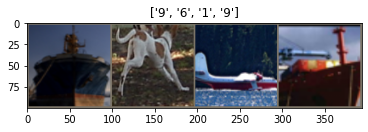

In [23]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Training
First, let's define our functions for training

In [24]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs), position=0):
        #print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        #print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            #if phase == 'train':
            #    scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #print('{} Loss: {:.4f} Acc: {:.4f}'.format(
            #    phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        #print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [25]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

#### Finetuning Model
Here, I will finetune our model to have *discriminative LR* that is, using different learning rate for each layers. I will start with a learning rate of 0.001 then will add 0.001 to every proceeding layers. Also, the fully connected layers will have a learning rate of 0.001

In [26]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

optimizer_ft = optim.SGD([
            {'params': model_ft.conv1.parameters(), 'lr': 0.001},
            {'params': model_ft.bn1.parameters(), 'lr': 0.002},
            {'params': model_ft.relu.parameters(), 'lr': 0.003},
            {'params': model_ft.maxpool.parameters(), 'lr': 0.004},
            {'params': model_ft.layer1.parameters(), 'lr': 0.005},
            {'params': model_ft.layer2.parameters(), 'lr': 0.006},
            {'params': model_ft.layer3.parameters(), 'lr': 0.007},
            {'params': model_ft.layer4.parameters(), 'lr': 0.008},
            {'params': model_ft.avgpool.parameters(), 'lr': 0.009},
            {'params': model_ft.fc.parameters(), 'lr': 0.001}
        ], lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
#exp_lr_scheduler = lr_scheduler.CyclicLR(optimizer_ft, base_lr=min_lr_list, max_lr=max_lr_list)

Time to train our model using the set parameters. We will follow the progressive resizing method here. Now, first with dataset of resolution 96x96

In [27]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

100%|██████████| 25/25 [19:01<00:00, 45.67s/it]

Training complete in 19m 2s
Best val Acc: 0.665483


Now, using the trained weight we will train the model again but with image of resolution 128x128

In [28]:
data_transforms, dataloaders, dataset_sizes, class_names, device = data_aug_trans(128, 128)
model_ft1 = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

100%|██████████| 25/25 [20:07<00:00, 48.28s/it]

Training complete in 20m 7s
Best val Acc: 0.828125


Finally with shape 256x256

In [29]:
data_transforms, dataloaders, dataset_sizes, class_names, device = data_aug_trans(256, 256)
model_ft2 = train_model(model_ft1, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

100%|██████████| 25/25 [30:54<00:00, 74.17s/it]

Training complete in 30m 54s
Best val Acc: 0.891335


Now, if we look at the best validation accuracy then we can see that,
   <table width="100%">
   <tr>
   <th>Model (Shape)</th>
   <th>Accuracy</th>
   </tr>
   <tr>
   <td>Model1 (96, 96)</td>
   <td>66.54%</td>
   </tr>
   <tr>
   <td>Model2 (128, 128)</td>
   <td>82.81%</td>
   </tr>
   <tr>
   <td>Model3 (256, 256)</td>
   <td>89.13%</td>
   </tr>
   </table>

So, we can see that the accuracy has improved

## Testing
Now with our model let's predict some images from test dataset

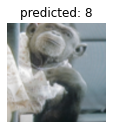

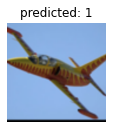

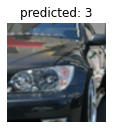

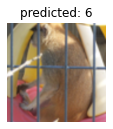

In [69]:
visualize_model(model_ft2, 4)

Just for your reference here is the class names and their labels for you to check

In [75]:
all_classes = open(DATA_DIR+"/stl10_binary/class_names.txt", "r")
all_classes = all_classes.read().split("\n")
all_classes.pop(-1)

print("Labels\tNames")
i = 1
for classs in all_classes:
  print("{}\t{}".format(i, classs))
  i += 1

Labels	Names
1	airplane
2	bird
3	car
4	cat
5	deer
6	dog
7	horse
8	monkey
9	ship
10	truck


## Conclusion
My model has produced an accuracy of 89.13% at best. I believe if the learning rates can be optimized further then it will give an even better result